# Decision Trees Lab

In this lab we will discover how to apply decision trees to regression and classification problems.

### 1: Build a regression tree

How do you build a decision tree? You're going to find out by building one in pairs!

Your training data is a tiny dataset of [used vehicle sale prices](../../assets/datasets/used_cars.csv). Your goal is to predict Price for out-of-sample data. Here are your instructions:

1. Read the data into Pandas.
- Explore the data by sorting, plotting, or split-apply-combine (aka `group_by`).
- Decide which feature is the most important predictor, and use that to make your first split. (Only binary splits are allowed!)
- After making your first split, you should actually split your data in Pandas into two parts, and then explore each part to figure out what other splits to make.
- Decide if you need additional splits along other features
- Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting. (As always, your goal is to build a model that generalizes well!)
- You are allowed to split on the same variable multiple times!
- Draw your tree on a piece of paper, making sure to label your leaves with the mean Price for the observations in that "bucket".
- When you're finished, review your tree to make sure nothing is backwards. (Remember: follow the left branch if the rule is true, and follow the right branch if the rule is false.)

In [48]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
% matplotlib inline

uc_df = pd.read_csv('./../../assets/datasets/used_cars.csv')
uc_df.head()

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car


In [49]:
pd.pivot_table(uc_df, values=['price'], index=['type'])

,price
type,
car,7790.909091
truck,2100.000000


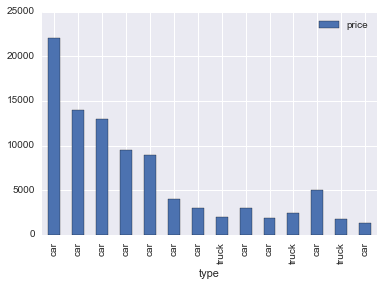

In [50]:
uc_df.plot(x='type', y='price', kind='bar')
plt.show()

According to the plot above, type seems to be a decent indicator of price, with trucks generaly being cheaper than cars.  This is also apparent in the pivot table above the graph.  I am going to say my first split is type.  I will take the mean from trucks and continue on with cars.

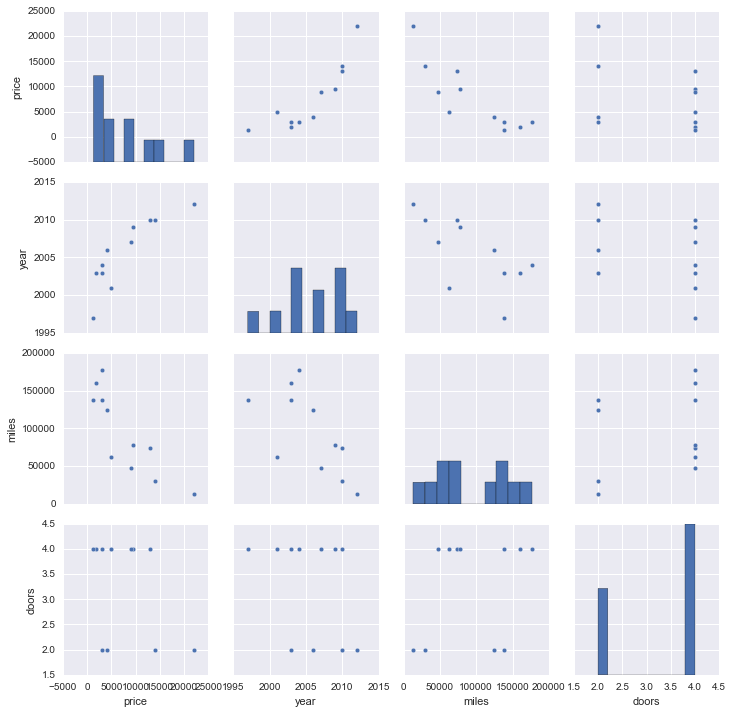

In [51]:
df_no_trucks = uc_df[uc_df['type'] == 'car']
sns.pairplot(df_no_trucks)
plt.show()

Looking at the pairplot above, it seems that year and miles are the best indicators of price.  I will look further into these with pivot tables.

In [52]:
pd.pivot_table(df_no_trucks, values=['price'], index=['miles'])

,price
miles,
13000,22000
30000,14000
47000,9000
62000,5000
73500,13000
78000,9500
124000,4000
138000,2150
160000,1900


In [53]:
pd.pivot_table(df_no_trucks, values=['price'], index=['year'])

,price
year,
1997,1300
2001,5000
2003,2450
2004,3000
2006,4000
2007,9000
2009,9500
2010,13500
2012,22000


After looking at these tables and the pairplot, I decided that miles was the best variable to split on.  I will take the mean from cars with over 75,000 miles.

In [54]:
df_und_75 = df_no_trucks[df_no_trucks['miles'] < 75000]
df_und_75

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
4,9000,2007,47000,4,car
11,5000,2001,62000,4,car


After that point, I would split it on the year (before and after 2008).  I think I would be done at that point and deal with the means from that split as the final means.

#### How does a computer build a regression tree?

The ideal approach would be for the computer to consider every possible partition of the feature space. However, this is computationally infeasible, so instead an approach is used called **recursive binary splitting:**

- Begin at the top of the tree.
- For every single predictor, examine every possible cutpoint, and choose the predictor and cutpoint such that the resulting tree has the **lowest possible mean squared error (MSE)**. Make that split.
- Repeat the examination for the two resulting regions, and again make a single split (in one of the regions) to minimize the MSE.
- Keep repeating this process until a stopping criteria is met.

**How does it know when to stop?**

1. We could define a stopping criterion, such as a **maximum depth** of the tree or the **minimum number of samples in the leaf**.
2. We could grow the tree deep, and then "prune" it back using a method such as "cost complexity pruning" (aka "weakest link pruning").

Method 2 involves setting a tuning parameter that penalizes the tree for having too many leaves. As the parameter is increased, branches automatically get pruned from the tree, resulting in smaller and smaller trees. The tuning parameter can be selected through cross-validation.

Note: **Method 2 is not currently supported by scikit-learn**, and so we will use Method 1 instead.


### 2: Build a regression tree in scikit-learn

Building a tree by hand was not so easy, and also not ideal. Let's use scikit-learn to build an optimal regression tree. Do the following:

- Map the `type` column to a binary variable
- Create a matrix `X` that contains the feature values and a vector `y` that contains the price values
- Split the data into train-test using a random state of 42 and test_size of 30%
- Import and initialize the `DecisionTreeRegressor` class from scikit-learn
- Fit it to the training set
- Predict the values of the test set
- Display the predicted and actual values in a plot
- Use r2_score to judge the goodness of the regression

In [55]:
# Map the type column to a binary variable
listy = []
for i in uc_df['type']:
    if i == 'car':
        listy.append(1)
    else:
        listy.append(0)
uc_df['car'] = listy
uc_df.drop('type', axis=1, inplace=True)

In [56]:
# Create a matrix X that contains the feature values and a vector y that contains the price values
X = uc_df[['year', 'miles', 'doors', 'car']]
y = uc_df['price']


In [57]:
# Split the data into train-test using a random state of 42 and test_size of 30%
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [60]:
# Import and initialize the DecisionTreeRegressor class from scikit-learn
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()

In [61]:
# Fit it to the training set
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [65]:
# Predict the values of the test set
y_pred = model.predict(X_test)

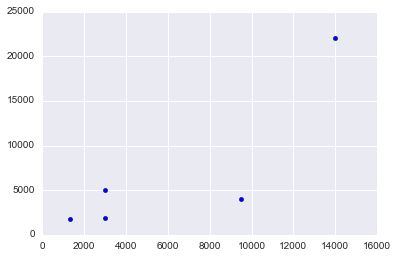

In [70]:
# Display the predicted and actual values in a plot
plt.scatter(y_pred, y_test)
plt.show()

In [67]:
# Use r2_score to judge the goodness of the regression
model.score(X_test, y_test)

0.65739162703757659

### 3.b Global parameters

The `DecisionTreeRegressor` offers few global parameters that can be changed at initialization. For example one can set the `max_depth` or the `min_samples_leaf` parameters and impose global constraints on the space of solutions.

1. Use `cross_val_score` with 3-fold cross validation to find the optimal value for the `max_depth` (explore values 1 - 10). Note that you will have to set `scoring='mean_squared_error'` as criterion for score. Always set `random_state=1`
- Plot the error as a function of `max_depth`

In [118]:
# Use cross_val_score with 3-fold cross validation to find the optimal value for the max_depth (explore values 1 - 10)
from sklearn.model_selection import cross_val_score
def check_scores(depth):
    model = DecisionTreeRegressor(max_depth=depth, random_state=1)
    return depth, cross_val_score(model, X, y, cv=3, scoring='mean_squared_error')
dicty = {}
for i in range(1,11):
    dicty[i] = check_scores(i)
mse = pd.DataFrame(dicty)
mmm = mse.transpose()
print mmm

     0                                           1
1    1  [-102800000.0, -4878500.0, -5937244.89796]
2    2      [-112050000.0, -5758500.0, -2039400.0]
3    3  [-112050000.0, -5517555.55556, -709218.75]
4    4      [-112050000.0, -6272000.0, -1045000.0]
5    5      [-112050000.0, -6272000.0, -1065000.0]
6    6      [-112050000.0, -6272000.0, -1065000.0]
7    7      [-112050000.0, -6272000.0, -1065000.0]
8    8      [-112050000.0, -6272000.0, -1065000.0]
9    9      [-112050000.0, -6272000.0, -1065000.0]
10  10      [-112050000.0, -6272000.0, -1065000.0]


//anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python2.7/site-packages/sklearn/metri

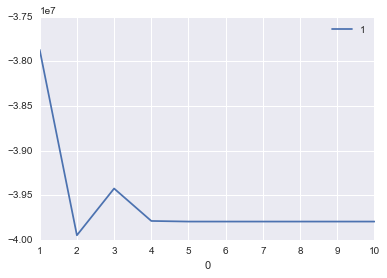

In [120]:
# Plot the error as a function of max_depth
listy = []
for i in mmm[1]:
    listy.append(np.mean(i))
mmm[1] = listy
mmm.plot(0, 1)
plt.show()

It appears that the optimal value for max depth is 2.

## 3.c Feature importances

The decision tree class exposes an attribute called `feature_importances_`.

1. Check the importance of each feature. what's the most important feature?

In [121]:
# Check the importance of each feature.
importance = pd.DataFrame(model.feature_importances_).transpose()
importance.columns = ['year', 'miles', 'doors', 'type']
importance

,year,miles,doors,type
0,0.994103,0.003104,0.0,0.002793


Year seems to be the most important feature by far, while doors doesn't appear to matter at all.

### 3.d Tree visualization

Follow the example in the [documentation](http://scikit-learn.org/stable/modules/tree.html) to visualize the tree.
You may have to install `pydot` and/or `graphviz` if you don't have them already.

In [122]:
from sklearn import tree
with open("X.dot", 'w') as f:
    f = tree.export_graphviz(model, out_file=f)

In [123]:
import os
os.unlink('X.dot')

In [124]:
import pydotplus 
dot_data = tree.export_graphviz(model, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("X.pdf") 

True

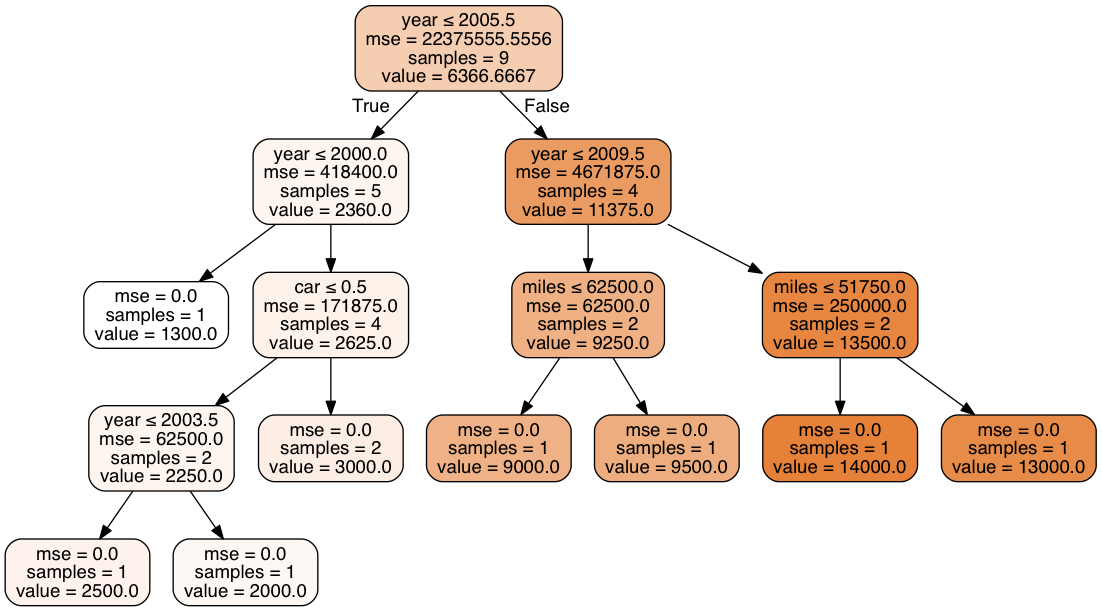

In [126]:
from IPython.display import Image  
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=X.columns,  
                         class_names='Price',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

That's awesome!

#### Interpreting a tree diagram

How do we read this decision tree?

**Internal nodes:**

- `samples` is the number of observations in that node before splitting
- `mse` is the mean squared error calculated by comparing the actual response values in that node against the mean response value in that node
- First line is the condition used to split that node (go left if true, go right if false)

**Leaves:**

- `samples` is the number of observations in that node
- `value` is the mean response value in that node
- `mse` is the mean squared error calculated by comparing the actual response values in that node against "value"

### Exercise 4: Use GridSearchCV to find te best Regression Tree

How do we know by pruning with max depth is the best model for us? Trees offer a variety of ways to pre-prune (that is, we tell a computer how to design the resulting tree with certain "gotchas").

Measure           | What it does
------------------|-------------
max_depth         | How many nodes deep can the decision tree go?
max_features      | Is there a cut off to the number of features to use?
max_leaf_nodes    | How many leaves can be generated per node?
min_samples_leaf  | How many samples need to be included at a leaf, at a minimum?  
min_samples_split | How many samples need to be included at a node, at a minimum?

1. Initialize reasonable ranges for all parameters and find the optimal combination using Grid Search.

In [138]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, param_grid = [
        {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': [1, 2, 3, 4],
    'max_leaf_nodes': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'min_samples_split': [2, 3, 4, 5]}])
gs.fit(X, y)
print 'The following are the best parameters for this model:', gs.best_params_

The following are the best parameters for this model: {'max_features': 2, 'max_leaf_nodes': 5, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 1}


## 4 Classification trees

Classification trees are very similar to regression trees. Here is a quick comparison:

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize a different criterion (discussed below)|

Note that classification trees easily handle **more than two response classes**! (How have other classification models we've seen handled this scenario?)

Here's an **example of a classification tree**, which predicts whether or not a patient who presented with chest pain has heart disease:

### 4.a Building a classification tree in scikit-learn
We'll build a classification tree using the [Car Dataset](./assets/datasets/cars.csv).

- Load the dataset in pandas
- Check for missing values
- Encode all the categorical features to booleans using `pd.get_dummies`
- Encode the labels using LabelEncoder
- Split X and y with train_test split like above
        train_test_split(X, y, test_size=0.3, random_state=42)
- Fit a classification tree with `max_depth=3` on all data
- Visualize the tree using graphviz
- Compute the feature importances
- Compute and display the confusion matrix
- Release the constraint of `max_depth=3` and see if the classification improves

In [145]:
# read data in
df = pd.read_csv('./../../assets/datasets/cars.csv')

# Check for missing values (there are none)
df.info()

# look at structure of dataset
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying           1728 non-null object
maint            1728 non-null object
doors            1728 non-null object
persons          1728 non-null object
lug_boot         1728 non-null object
safety           1728 non-null object
acceptability    1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [214]:
# Encode the labels using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = df['acceptability']
le.fit(y)
y = le.transform(y)

# Encode all the categorical features to booleans using pd.get_dummies
X = pd.get_dummies(df[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
X.head()
y

array([2, 2, 2, ..., 2, 1, 3])

In [215]:
# Split X and y with train_test split like above
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [216]:
# Fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

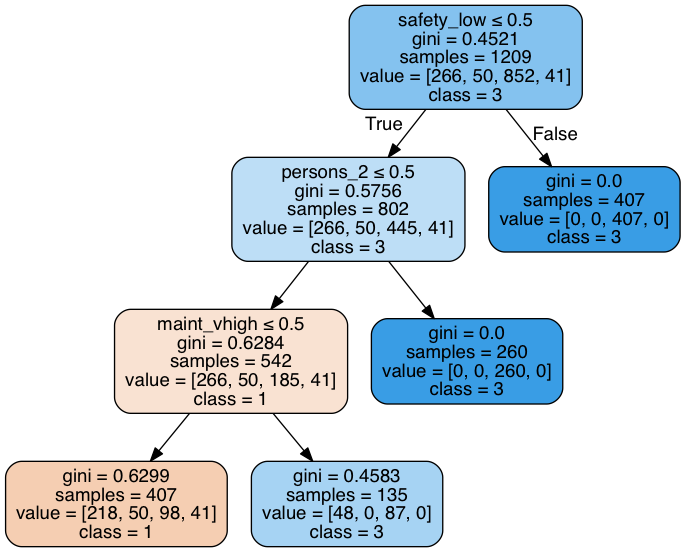

In [226]:
# Visualize the tree using graphviz
with open("X.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

os.unlink('X.dot')
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("X.pdf")
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         class_names='1234',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [218]:
# Compute the feature importances
importance = pd.DataFrame(clf.feature_importances_).transpose()
importance.columns = [X.columns]
importance.transpose()

,0
buying_high,0.000000
buying_low,0.000000
buying_med,0.000000
buying_vhigh,0.000000
maint_high,0.000000
maint_low,0.000000
maint_med,0.000000
maint_vhigh,0.097928
doors_2,0.000000
doors_3,0.000000


It appears that most of the variables are useless according to this readout.  The only useful ones appear to be safety_low, persons_2, and maint_vhigh.

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [220]:
# Compute and display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
con = pd.DataFrame(confusion_matrix(y_test, y_pred))
con.index = ['acc','good','unacc', 'vgood']
con.columns = ['pred acc','pred good','pred unacc', 'pred vgood']
con

,pred acc,pred good,pred unacc,pred vgood
acc,94,0,24,0
good,19,0,0,0
unacc,32,0,326,0
vgood,24,0,0,0


In [221]:
# Release the constraint of max_depth=3 and see if the classification improves
clf2 = DecisionTreeClassifier()
clf2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [222]:
y_pred = clf2.predict(X_test)
con = pd.DataFrame(confusion_matrix(y_test, y_pred))
con.index = ['acc','good','unacc', 'vgood']
con.columns = ['pred acc','pred good','pred unacc', 'pred vgood']
con

,pred acc,pred good,pred unacc,pred vgood
acc,104,5,6,3
good,1,17,0,1
unacc,2,0,356,0
vgood,3,2,0,19


Classification improved a lot!

## Bonus

Visualize the last tree. Can you make sense of it? What does this teach you about decision tree interpretability?


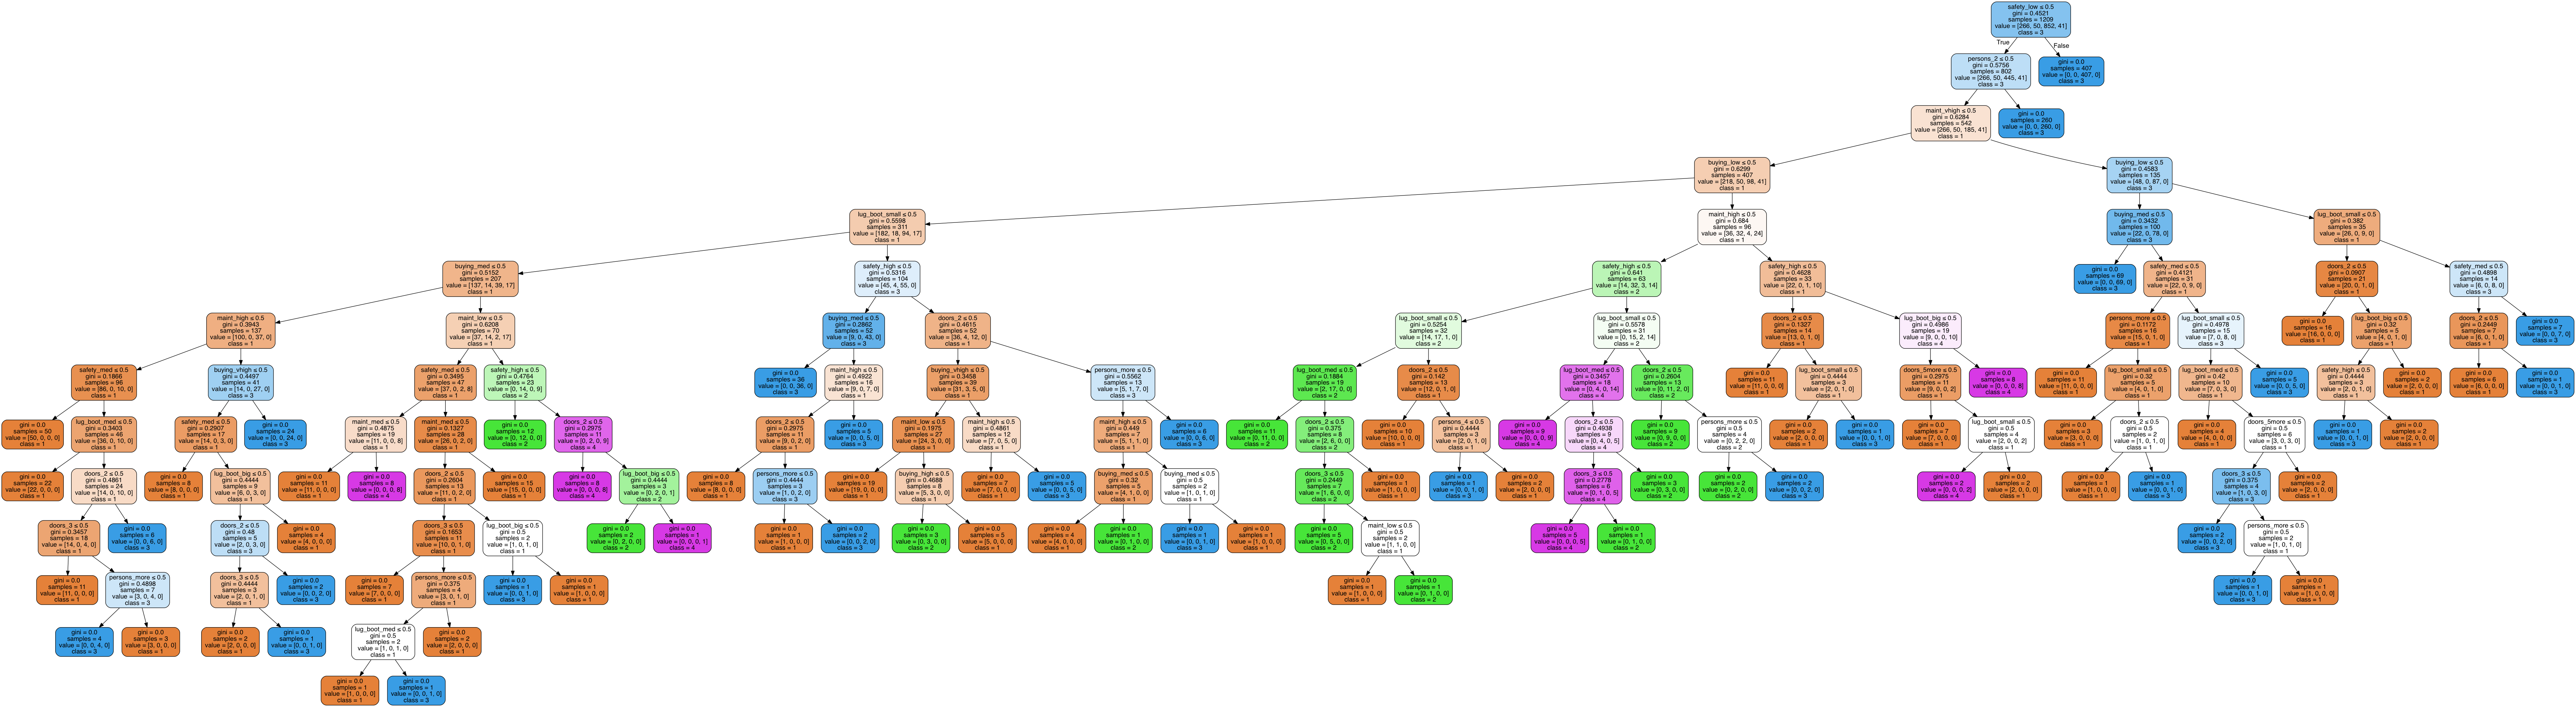

In [225]:
with open("X.dot", 'w') as f:
    f = tree.export_graphviz(clf2, out_file=f)

os.unlink('X.dot')
dot_data = tree.export_graphviz(clf2, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("X.pdf")
dot_data = tree.export_graphviz(clf2, out_file=None, 
                         feature_names=X.columns,  
                         class_names='1234',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

That is massive.  I don't think I could make sense out of that.  I think this teaches me that decision trees can quickly become so complex that they are generally uninterpretable.